## Testing the Google Vision API
Project by Freija D. January 2018

The current hand-classified birdometer (see [the birdometer project page](http://freija.net/projects/2017-10-21_birdometer.html) for details) image set has (excluding invalid entries) 664 images with a bird (class 1), 3194 images without a bird (class 0) for a total of 3858 labeled images. It is clear that the labeled data has many more class 0 images than class 1.

All hand-classified images from the birdometer project were also labeled by the Google Vision API, using a quick Python script. That script did the following:
 * Loops over all hand-classified images.
 * Contacts the Google Vision API for each image (that has not been processed yet) to request annotation.
 * Stores the labels and classification in a local CSV file.

This notebook reads in the labels for the hand-classified images. There 52 unique labels overall: 41 for the class 1 images (bird) and 32 for the class 0 images (no bird). There is significant overlap in labels between the two classes as we can expect from images that are so similar. The images with the birds have a larger variety of labels. This is also expected, since there is an additional element (bird) present. Using the Python wordcloud library and excluding the two most common labels: grass and plant, two wordclouds are created: for the images with and without a bird. Each wordcloud shows all labels, the font size represents the frequency the label was assigned. 

See [freija.net](http://freija.net) for more details on the birdometer and the Google Vision API tests.

## Imports

In [20]:
# Group all imports here
import io
import os
import re
import csv
import random
from os.path import join
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import pandas as pd
import numpy as np

## Helper functions

In [21]:
def get_image_list(path):
    ''' Retrieve the list of available labeled images.
    Input:
        <string>: path to CSV file
    Output:
        <list>: a list of lists
    '''
    image_list = []
    with open(path, 'r') as infile:
        reader = csv.reader(infile)
        for row in reader:
            image_list.append(row)
    return image_list

In [22]:
def get_label(image_detail):
    ''' Return the label of the image.
    Input:
        <list>: image details like this: ['2017-09-20_17.04.43_9.jpg', 'y', 'n']
    Output:
        <int>: the label of the image : 0 (no bird), 1 (bird), -1 (unknown)
    '''
    # The label needs to be 1 if image_detail[1]=='y' and 0 if not.
    if image_detail[1] == 'y':
        return 1
    elif image_detail[1] == 'n':
        return 0
    else:
        return -1  # Something is wrong

In [23]:
def unpack_labelstring(string):
    ''' Unpacks the unfortunate format for the label string. This is needed
    because getting the labels out of the Google Vision API JSON format is a bit of a mess.
    
    Input: 
        <string>: the string that contains the labels, from the Google Vision API annotation.
    Output:
        <list>: a list of the labels that were contained in that string.
    '''
    label_list = []
    if len(string) < 10:
        return label_list
    for substring in string.split(','):
        # The following line splits the string by label and grabs the label name.
        # IMPORTANT note: the labels are not always a single word,
        # notable example is "grass family"
        # For now, decision is to add underscores so that it is treated as a single label
        label_list.append(substring.split('\n')[1].split('\"')[1].replace(" ","_"))
    return label_list

## Analyzing the labels

In [24]:
# Grab the Google Vision API labels from the file
google_labels = get_image_list('images.google.csv.birds')
# Get the bird and nobird labels
bird_labels = []
nobird_labels = []
count_birds = 0
count_nobirds = 0
# Loop over all images and collect the labels in the correct list.
# The file also contains the hand-classification.
for result in google_labels:
    labels_list = unpack_labelstring(result[1])
    bird = get_label(eval(result[0]))
    if bird == 1:  # This image was hand-classified as containing a bird
        bird_labels += labels_list
        count_birds += 1
    elif bird == 0:  # This image was hand-classifued as not containing a bird
        nobird_labels += labels_list
        # This next check was added to make sure we are not seeing the same label
        # twice for the same image. That would be an indication of a bug
        # in the unpacking.
        if len(set(labels_list)) < len(labels_list):
            print('\nWarning: duplicate labels detected:\n')
            print(result[1], labels_list)
        count_nobirds += 1
# Make sure the  numbers make sense
print(len(google_labels), count_birds, count_nobirds)

3858 664 3194


In [25]:
# We now have the bird and no-bird lists.
# Let's count how many times a label occurs.
cb = Counter()
cn = Counter()
for label in bird_labels:
    cb[label] += 1
for label in nobird_labels:
    cn[label] += 1
all_labels = bird_labels + nobird_labels
# Print the results. Keep in mind that there are many more class 0 images than class 1.
print('There are {} unique labels in total, {} for class 1 (bird) and {} for class 2 (no bird)'.format(len(set(all_labels)), len(set(bird_labels)), len(set(nobird_labels))))
print('\nMost common labels for class 0 (no bird):\n')
print(cn.most_common())
print('\nMost common labels for class 1 (bird):\n')
print(cb.most_common())

# This is were it initially became clear that labels can consist of multiple words, the initial result showed
# as most common label for class 0: ('grass', 5476). Hmm.. there are only 3194 class 0 images. This was
# caused by the "grass family" label. This was fixed by adjusting the unpack_labelstring function: it adds
# underscores to the multi-word labels

There are 54 unique labels in total, 43 for class 1 (bird) and 33 for class 2 (no bird)

Most common labels for class 0 (no bird):

[('grass', 3193), ('plant', 3130), ('yellow', 2916), ('tree', 2421), ('grass_family', 2283), ('soil', 1878), ('flora', 1092), ('wheel', 1065), ('lawn', 705), ('red', 277), ('leaf', 258), ('flower', 199), ('tire', 134), ('water', 125), ('play', 117), ('sunglasses', 101), ('car', 96), ('green', 75), ('eyewear', 75), ('automotive_tire', 60), ('petal', 47), ('sunlight', 43), ('fun', 40), ('pink', 36), ('glasses', 29), ('wildflower', 18), ('motor_vehicle', 7), ('organism', 6), ('magenta', 6), ('vertebrate', 6), ('vision_care', 3), ('personal_protective_equipment', 1), ('vehicle', 1)]

Most common labels for class 1 (bird):

[('grass', 601), ('plant', 516), ('flora', 395), ('red', 303), ('fauna', 302), ('leaf', 247), ('bird', 225), ('flower', 220), ('beak', 167), ('yellow', 143), ('tree', 121), ('vertebrate', 112), ('fish', 93), ('grass_family', 56), ('soil', 51

## Creating the wordclouds

In [26]:
# Now we create the two word-clouds: one for each class.
# We use the wordcloud python library (https://github.com/amueller/word_cloud)

# Shuffle the labels. This is needed because many times, the same order of labels appears, which 
# will cause label-combinations to show up in the wordcloud.
random.shuffle(bird_labels)
random.shuffle(nobird_labels)
stopwords = set()
stopwords.add("grass")
stopwords.add("plant")
nbird_labels = ' '.join(bird_labels)
nnobird_labels = ' '.join(nobird_labels)
bird_wordcloud = WordCloud(width=400, height=400,  margin=3, background_color="white", stopwords=stopwords, max_words=41).generate(nbird_labels)
nobird_wordcloud = WordCloud(width=400, height=400,  margin=3, background_color="white", stopwords=stopwords, max_words=32).generate(nnobird_labels)

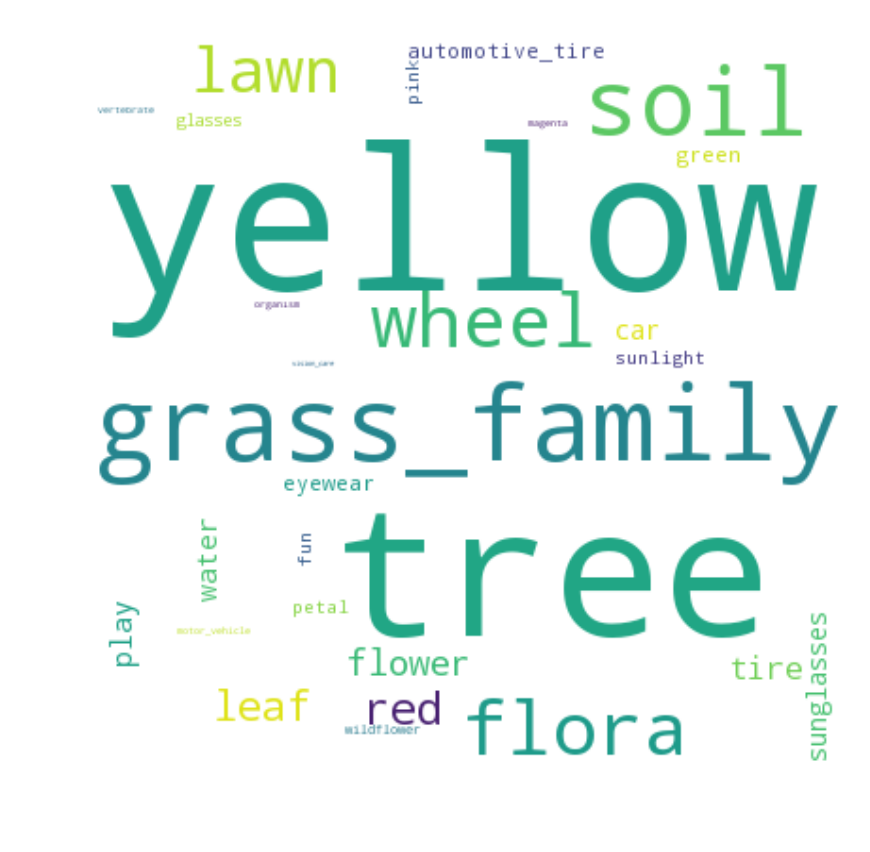

In [27]:
# Class 0
plt.figure(figsize=(5, 5), dpi=200)
plt.imshow(nobird_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

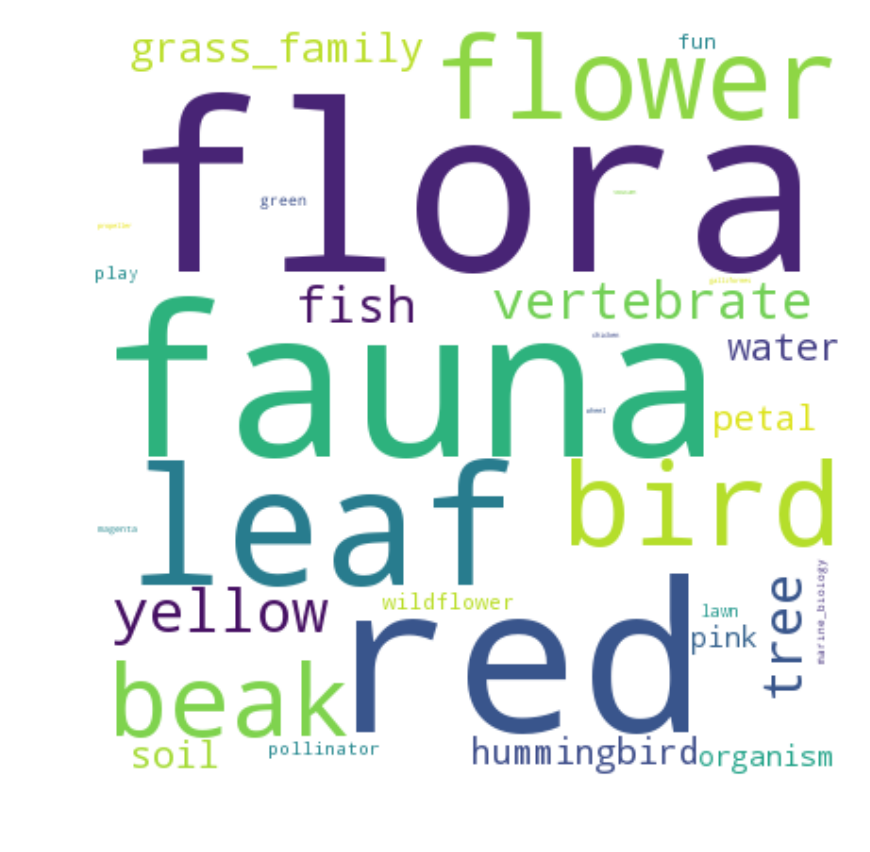

In [28]:
# Class 1
plt.figure(figsize=(5, 5), dpi=200)
plt.imshow(bird_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## More detailed look

In [29]:
# Create a pandas DataFrame for easy manipulation
df = pd.DataFrame()
unique_labels = list(set(all_labels))
# The first column will be the labels themself
df['labels'] = unique_labels

In [30]:
# Now we want two clumns: 1 for each class. The values are the frequency (in percent of images) that the label
# appears in that class .
cnd = dict(cn)
cbd = dict(cb)
df['class 0'] = df['labels'].apply(lambda x: 100*cnd[x]/count_nobirds if x in cnd.keys() else 0)
df['class 1'] = df['labels'].apply(lambda x: 100*cbd[x]/count_birds if x in cbd.keys() else 0)
# Sort the DataFrame by class 0 frequency.
df.sort_values(by='class 0', inplace=True,ascending=False)
# Display the DataFrame
df

,labels,class 0,class 1
31,grass,99.968691,90.512048
1,plant,97.996243,77.710843
38,yellow,91.296180,21.536145
26,tree,75.798372,18.222892
15,grass_family,71.477771,8.433735
36,soil,58.797746,7.680723
16,flora,34.189105,59.487952
8,wheel,33.343770,0.301205
29,lawn,22.072636,1.204819
27,red,8.672511,45.632530


### Discussion

It is nice to see that the 'fauna' and 'bird' labels do not show up for the class 0 images, whereas they do for about 44.5 and 34% of the class 1 images respectively. The current method does not make use of the probabilities that the Google Vision API assigns to each label. It would be interesting to incorporate those as weights.